# Chapter 15: Autoencoders

Autoencoders are an unsupervised neural network architecture who are tasked with reproducing their input. They do so by learning how to encode their inputs using hidden layers that are _smaller_ than the input layer. This forces the model to learn an efficient representation of the data, called _codings_.

Below is some setup code which the author uses for the code throughout the chapter.



In [0]:
import numpy as np
import os
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Plot styling.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Code for saving figures.
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, 'images', '{}.png'.format(fig_id))
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

In [0]:
!mkdir images

## Performing PCA with an Undercomplete Linear Autoencoder

An autoencoder with only linear activation functions that uses MSE as the loss function can be shown to be equivalent to PCA (Chapter 8).

In [0]:
# Create a 3D dataset.

import numpy.random as rnd

rnd.seed(42)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + (np.sin(angles) / 2) + (noise * rnd.randn(m) / 2)
data[:, 1] = (np.sin(angles) * 0.7) + (noise * rnd.randn(m) / 2)
data[:, 2] = (data[:, 0] * w1) + (data[:, 1] * w2) + (noise * rnd.randn(m))

In [0]:
# Scale the data with StandardScaler.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [0]:
# Define the model graph.

import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [0]:
# Training the autoencoder.

n_iterations = 100
codings = hidden

with tf.Session() as sess:
  init.run()
  for i in range(n_iterations):
    training_op.run(feed_dict={X: X_train})
  codings_val = codings.eval(feed_dict={X: X_test})

Saving figure linear_autoencoder_pca_plot


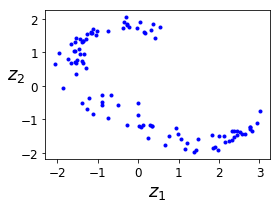

In [0]:
# Plotting the figure.

fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## Stacked Autoencoders

Autoencoders with multiple hidden layers are called _stacked autoencoders_ (or _deep autoencoders_). You must be wary that if the autoencoder is too deep, it may just learn how to reproduce the training set, leading to overfitting. Below is a TensorFlow implementation of a stacked autoencoder with 3 hidden layers used for generating handwritten digits using the MNIST dataset.

In [0]:
# Downloading the data.

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Train all layers at once

The example below trains all of the hidden layers of the stacked autoencoder at once.

In [0]:
# Define the model graph.

from functools import partial

reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = n_hidden1
n_outputs = n_inputs
n_outputs = n_inputs

learning_rate = 0.001
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

dense = partial(tf.layers.dense, activation=tf.nn.relu,
                kernel_initializer=he_init, kernel_regularizer=regularizer)

hidden1 = dense(X, n_hidden1)
hidden2 = dense(hidden1, n_hidden2)
hidden3 = dense(hidden2, n_hidden3)
outputs = dense(hidden3, n_outputs, activation=None)

loss = tf.reduce_mean(tf.square(outputs - X))
opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [0]:
# Train the model.

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for i in range(n_batches):
      print('\r{}%'.format((100 * i) // n_batches), end="")
      sys.stdout.flush()
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    loss_train = loss.eval(feed_dict={X: X_batch})
    print("\r{}".format(epoch), "Train MSE:", loss_train)
    saver.save(sess, './my_model_all_layers.ckpt')

0 Train MSE: 0.015861776
1 Train MSE: 0.014257669
2 Train MSE: 0.013384858
3 Train MSE: 0.012632973
4 Train MSE: 0.012566684


In [0]:
# Define a plotting function.

def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
  with tf.Session() as sess:
    if model_path:
      saver.restore(sess, model_path)
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})
  for digit_idx in range(n_test_digits):
    plt.subplot(n_test_digits, 2, (digit_idx * 2) + 1)
    plot_image(X_test[digit_idx])
    plt.subplot(n_test_digits, 2, (digit_idx * 2) + 2)
    plot_image(outputs_val[digit_idx])

Saving figure reconstruction_plot


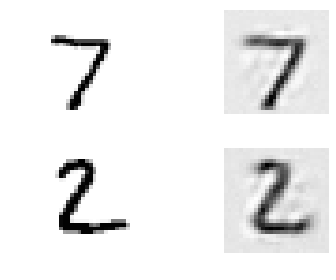

In [0]:
show_reconstructed_digits(X, outputs, './my_model_all_layers.ckpt')
save_fig('reconstruction_plot')

### Tying Weights

When you are using a near-symmetric autoencoder (like the one above) then you can _tie the weights_ of the decoder layers to th weights of the encoder layers. Specifically, if the autoencoder has $N$ layers and $\mathbf{W}_L$ is the weights tensor of the $L$<sup>th</sup> layer, then the decoder layer weights can be defined as

$$ \mathbf{W}_{N-L+1} = \mathbf{W}^{\;\,T}_L $$

Below is a TensorFlow implementation of a stacked autoencoder which ties weights.

In [0]:
# Defining the model graph.

reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = n_hidden1
n_outputs = n_inputs
n_outputs = n_inputs

learning_rate = 0.001
l2_reg = 0.00005

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

weights1_init = he_init([n_inputs, n_hidden1])
weights2_init = he_init([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32)
weights2 = tf.Variable(weights2_init, dtype=tf.float32)
weights3 = tf.transpose(weights2)
weights4 = tf.transpose(weights1)

bias = lambda n: tf.Variable(tf.zeros(n))
bias1 = bias(n_hidden1)
bias2 = bias(n_hidden2)
bias3 = bias(n_hidden3)
bias4 = bias(n_outputs)

hidden = lambda X, W, b: tf.nn.elu(tf.matmul(X, W) + b)
hidden1 = hidden(X, weights1, bias1)
hidden2 = hidden(hidden1, weights2, bias2)
hidden3 = hidden(hidden2, weights3, bias3)
outputs = tf.matmul(hidden3, weights4) + bias4

reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
loss = reconstruction_loss + regularizer(weights1) + regularizer(weights2)
opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [0]:
# Train the model.

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for i in range(n_batches):
      print('\r{}%'.format((100 * i) // n_batches), end="")
      sys.stdout.flush()
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
    print('\r{}'.format(epoch), 'Train MSE:', loss_train)
    saver.save(sess, './my_model_all_layers.ckpt')

0 Train MSE: 0.0059264963
1 Train MSE: 0.0042326236
2 Train MSE: 0.004368516
3 Train MSE: 0.004215196
4 Train MSE: 0.004000963


Saving figure tying_weight_reconstruction_plot


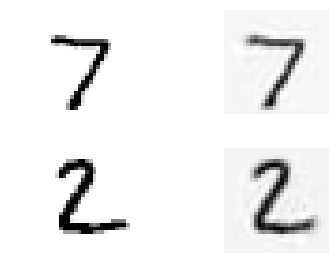

In [0]:
show_reconstructed_digits(X, outputs, './my_model_all_layers.ckpt')
save_fig('tying_weight_reconstruction_plot')

### Train One Autoencoder at a Time in Multiple Graphs

You can train a stacked autoencoder in parts:

1. First you train the model to reproduce the input layer only using one hidden layer.

2. You train an autoencoder which tries to reproduce the output of the first hidden layer (which trains the second and third hidden layer).

You can then combine the two results for a fully-functional autoencoder. Below is an implementation of training a stacked autoencoder this way using multiple TensorFlow graphs.

In [0]:
# Defining a function for training an autoencoder in the first 2 steps.

reset_graph()

def train_autoencoder(X_train, n_units, n_epochs, batch_size,
                      learning_rate=0.001, l2_reg=0.00005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
  graph = tf.Graph()
  with graph.as_default():
    tf.set_random_seed(seed)

    n_inputs = X_train.shape[1]

    X = tf.placeholder(tf.float32, shape=(None, n_inputs))

    he_init = tf.contrib.layers.variance_scaling_initializer()
    regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    dense = partial(tf.layers.dense, kernel_initializer=he_init,
                    kernel_regularizer=regularizer)
    
    hidden = dense(X, n_units, activation=hidden_activation, name='hidden')
    outputs = dense(hidden, n_inputs, activation=output_activation,
                    name='outputs')

    reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] + reg_losses)

    opt = tf.train.AdamOptimizer(learning_rate)
    training_op = opt.minimize(loss)

    init = tf.global_variables_initializer()

  with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
      n_batches = len(X_train) // batch_size
      for i in range(n_batches):
        print('\r{}%'.format(100 * i // n_batches), end='')
        sys.stdout.flush()
        indices = rnd.permutation(len(X_train))[:batch_size]
        X_batch = X_train[indices]
        sess.run(training_op, feed_dict={X: X_batch})
      loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
      print('\r{}'.format(epoch), 'Train MSE:', loss_train)
    params = {
      var.name: var.eval()
      for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    }
    hidden_val = hidden.eval(feed_dict={X: X_train})
  return hidden_val, params['hidden/kernel:0'], params['hidden/bias:0'], \
      params['outputs/kernel:0'], params['outputs/bias:0']

In [0]:
# First step of training.

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images,
                                                  n_units=256, n_epochs=5,
                                                  batch_size=150,
                                                  output_activation=None)

0 Train MSE: 0.011589399
1 Train MSE: 0.0058716172
2 Train MSE: 0.0050500864
3 Train MSE: 0.004723415
4 Train MSE: 0.0044162828


In [0]:
# Second step of training.

_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_units=128, n_epochs=5,
                                      batch_size=150)

0 Train MSE: 0.036738154
1 Train MSE: 0.013828675
2 Train MSE: 0.006784402
3 Train MSE: 0.0043382
4 Train MSE: 0.0035973343


In [0]:
# Putting the results together.

reset_graph()

n_inputs = 28 ** 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

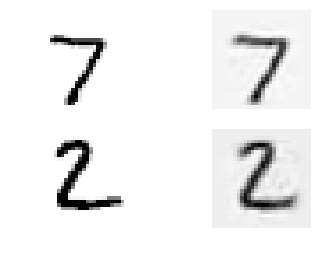

In [0]:
show_reconstructed_digits(X, outputs)

### Training One Autoencoder at a Time in a Single Graph

Below is another implementation of the same technique, but this time using just a single TensorFlow graph.

In [0]:
# Defining the graph.

reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 256
n_hidden2 = 128
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

X = tf.placeholder(tf.float32, shape=(None, n_inputs))

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

init_weights = lambda n1, n2, name: \
    tf.Variable(he_init([n1, n2]), dtype=tf.float32, name=name)
W1 = init_weights(n_inputs, n_hidden1, 'weights1')
W2 = init_weights(n_hidden1, n_hidden2, 'weights2')
W3 = init_weights(n_hidden2, n_hidden3, 'weights3')
W4 = init_weights(n_hidden3, n_outputs, 'weights4')

init_bias = lambda n, name: \
    tf.Variable(tf.zeros(n), dtype=tf.float32, name=name)
b1 = init_bias(n_hidden1, name='bias1')
b2 = init_bias(n_hidden2, name='bias2')
b3 = init_bias(n_hidden3, name='bias3')
b4 = init_bias(n_outputs, name='bias4')

hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate)

In [0]:
# Defining the training objective for the 1st phase of training.

with tf.name_scope('phase1'):
  phase1_outputs = tf.matmul(hidden1, W4) + b4
  phase1_reconstruction_loss = tf.reduce_mean(tf.square(X - phase1_outputs))
  phase1_reg_loss = regularizer(W1) + regularizer(W4)
  phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
  phase1_training_op = optimizer.minimize(phase1_loss)

In [0]:
# Defining the training objective for the 2nd phase of training.

with tf.name_scope('phase2'):
  phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden1 - hidden3))
  phase2_reg_loss = regularizer(W2) + regularizer(W3)
  phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
  train_vars = [W2, b2, W3, b3]
  phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)

In [0]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [0]:
# Training the model.

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = \
    [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for phase in range(2):
    print('Training phase {}'.format(phase + 1))
    for epoch in range(n_epochs):
      n_batches = mnist.train.num_examples // batch_size
      for i in range(n_batches):
        print('\r{}%'.format(100 * i // n_batches), end='')
        sys.stdout.flush()
        X_batch, _ = mnist.train.next_batch(batch_size)
        sess.run(training_ops[phase], feed_dict={X: X_batch})
      loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
      print('\r{}'.format(epoch), 'Train MSE:', loss_train)
      saver.save(sess, './my_model_one_at_a_time.ckpt')
  loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
  print('Test MSE:', loss_test)

Training phase 1
0 Train MSE: 0.018336492
1 Train MSE: 0.019637663
2 Train MSE: 0.019277904
3 Train MSE: 0.018733133
4 Train MSE: 0.020028505
Training phase 2
0 Train MSE: 0.0037001013
1 Train MSE: 0.0036114932
2 Train MSE: 0.0036930295
3 Train MSE: 0.0037119866
4 Train MSE: 0.004263958
Test MSE: 0.022761209


### Caching the Frozen Layer Outputs

One way to speed up training is to cache the outputs of the previous phase of training.

In [0]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = \
    [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for phase in range(2):
    print('Training phase {}'.format(phase + 1))
    if phase == 1:
      hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
    for epoch in range(n_epochs):
      n_batches = mnist.train.num_examples // batch_size
      for i in range(n_batches):
        print('\r{}%'.format(100 * i // n_batches), end='')
        sys.stdout.flush()
        if phase == 1:
          indices = rnd.permutation(mnist.train.num_examples)
          hidden1_batch = hidden1_cache[indices[:batch_size]]
          feed_dict = {hidden1: hidden1_batch}
        else:
          X_batch, _ = mnist.train.next_batch(batch_size)
          feed_dict = {X: X_batch}
        sess.run(training_ops[phase], feed_dict=feed_dict)
      loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
      print('\r{}'.format(epoch), 'Train MSE:', loss_train)
      saver.save(sess, './my_model_cache_frozen.ckpt')
  loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
  print('Test MSE:', loss_test)

Training phase 1
0 Train MSE: 0.017883915
1 Train MSE: 0.018957019
2 Train MSE: 0.019209469
3 Train MSE: 0.019031227
4 Train MSE: 0.019129302
Training phase 2
0 Train MSE: 0.0036775959
1 Train MSE: 0.003967436
2 Train MSE: 0.0039204685
3 Train MSE: 0.003805287
4 Train MSE: 0.0039625303
Test MSE: 0.022798782


### Visualizing the Reconstructions

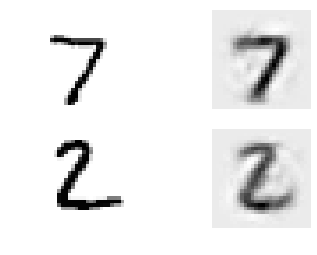

In [0]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, './my_model_one_at_a_time.ckpt')
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Visualizing the Extracted Features

Below is code which plots the feature weights that the first hidden layer learned during training. You can even see some feature maps that resemble actual digits.

Saving figure extracted_features_plot


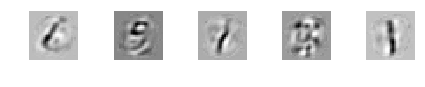

In [0]:
with tf.Session() as sess:
  saver.restore(sess, './my_model_one_at_a_time.ckpt')
  weights1_val = W1.eval()

for i in range(5):
  plt.subplot(1, 5, i + 1)
  plot_image(weights1_val.T[i])

save_fig('extracted_features_plot')
plt.show()

## Unsupervised Pretraining

In the code below, we create a neural network for MNIST classification. We first train it alone and see how it performs. Next, we train it again using the features that the unsupervised autoencoder learned and see how the performance compares to when we just did the supervised training alone.

In 2006 Geoffrey Hinton et al. discovered that DNNs can be pretrained using unsupervised learning. They used restricted Boltzmann machines (RBFs) but Yoshua Bengio et al. showed that autoencoders worked just as well.

In [0]:
# Defining the graph for both training techniques.

reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 256
n_hidden2 = 128
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.00005

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.int32, shape=(None))

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

init_weights = lambda n1, n2, name: \
    tf.Variable(he_init([n1, n2]), dtype=tf.float32, name=name)
W1 = init_weights(n_inputs, n_hidden1, 'weights1')
W2 = init_weights(n_hidden1, n_hidden2, 'weights2')
W3 = init_weights(n_hidden2, n_hidden2, 'weights3')
W4 = init_weights(n_hidden2, n_outputs, 'weights4')

# Don't need to redefine init_bias()
b1 = init_bias(n_hidden1, name='bias1')
b2 = init_bias(n_hidden2, name='bias2')
b3 = init_bias(n_hidden2, name='bias3')
b4 = init_bias(n_outputs, name='bias4')

hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
logits = tf.matmul(hidden3, W4) + b4

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
reg_loss = regularizer(W1) + regularizer(W2) + regularizer(W3)
loss = xentropy + reg_loss

opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(loss)
pretrain_training_op = opt.minimize(loss, var_list=[W3, b3])

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
pretrain_saver = tf.train.Saver([W1, W2, b1, b2])

In [0]:
# Regular training without pretraining.

n_epochs = 10
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = n_labeled_instances // batch_size
    for i in range(n_batches):
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      X_batch, y_batch = \
          mnist.train.images[indices], mnist.train.labels[indices]
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    acc_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
    print('\r{}'.format(epoch), 'Train accuracy:', acc_val, end=' ')
    saver.save(sess, './my_model_supervised.ckpt')
    acc_val = accuracy.eval(feed_dict={
        X: mnist.test.images,
        y: mnist.test.labels,
    })
    print('Test accuracy:', acc_val)

0 Train accuracy: 0.9266667 Test accuracy: 0.932
1 Train accuracy: 0.96 Test accuracy: 0.9355
2 Train accuracy: 0.97333336 Test accuracy: 0.9345
3 Train accuracy: 0.99333334 Test accuracy: 0.9433
4 Train accuracy: 0.97333336 Test accuracy: 0.9491
5 Train accuracy: 0.98 Test accuracy: 0.9485
6 Train accuracy: 0.9866667 Test accuracy: 0.9525
7 Train accuracy: 1.0 Test accuracy: 0.9393
8 Train accuracy: 0.9866667 Test accuracy: 0.951
9 Train accuracy: 0.99333334 Test accuracy: 0.9479


In [0]:
# Now using the layers that were pre-trained. This technique both sped
# up training and made the model perform better!

with tf.Session() as sess:
  init.run()
  pretrain_saver.restore(sess, './my_model_cache_frozen.ckpt')
  for epoch in range(n_epochs):
    n_batches = n_labeled_instances // batch_size
    for i in range(n_batches):
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      X_batch, y_batch = \
          mnist.train.images[indices], mnist.train.labels[indices]
      sess.run(pretrain_training_op, feed_dict={X: X_batch, y: y_batch})
    acc_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
    print('\r{}'.format(epoch), 'Train accuracy:', acc_val, end=' ')
    saver.save(sess, './my_model_supervised.ckpt')
    acc_val = accuracy.eval(feed_dict={
        X: mnist.test.images,
        y: mnist.test.labels,
    })
    print('Test accuracy:', acc_val)

0 Train accuracy: 0.94666666 Test accuracy: 0.9168
1 Train accuracy: 0.94 Test accuracy: 0.9345
2 Train accuracy: 0.96 Test accuracy: 0.9429
3 Train accuracy: 0.97333336 Test accuracy: 0.9508
4 Train accuracy: 0.96666664 Test accuracy: 0.9519
5 Train accuracy: 0.9866667 Test accuracy: 0.9558
6 Train accuracy: 0.98 Test accuracy: 0.9555
7 Train accuracy: 0.99333334 Test accuracy: 0.9584
8 Train accuracy: 0.97333336 Test accuracy: 0.9581
9 Train accuracy: 0.97333336 Test accuracy: 0.9586


## Stacked Denoising Autoencoder

In a [2008 paper](https://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf) Pascal Vincent et al. showed that autoencoders could be used for feature extraction. A [2010 paper by Vincent et al.](http://jmlr.csail.mit.edu/papers/volume11/vincent10a/vincent10a.pdf) introduced _stacked denoising autoencoders_.

You can also add Gaussian noise to the inputs, like in the example below:

In [0]:
reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 256
n_hidden2 = 128
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
X_noise = X + (noise_level * tf.random_normal(tf.shape(X)))

hidden1 = tf.layers.dense(X_noise, n_hidden1, activation=tf.nn.elu)
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu)
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu)
outputs = tf.layers.dense(hidden3, n_outputs)

mse = tf.reduce_mean(tf.square(X - outputs))
opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(mse)

init = tf.global_variables_initializer()

In [63]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for i in range(n_batches):
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      X_batch, y_batch = \
          mnist.train.images[indices], mnist.train.labels[indices]
      sess.run(training_op, feed_dict={X: X_batch})
    mse_val = mse.eval(feed_dict={X: X_batch})
    print('\r{}'.format(epoch), 'Train MSE:', mse_val)

0 Train MSE: 0.037528284
1 Train MSE: 0.033405814
2 Train MSE: 0.033303495
3 Train MSE: 0.033667754
4 Train MSE: 0.030195063
5 Train MSE: 0.031798024
6 Train MSE: 0.029453682
7 Train MSE: 0.030101554
8 Train MSE: 0.029107567
9 Train MSE: 0.028518533


Now implementing a denoising stacked autoencoder using dropout:

In [0]:
reset_graph()

n_inputs = 28 ** 2
n_hidden1 = 256
n_hidden2 = 128
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=())

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
X_drop = tf.layers.dropout(X, rate=dropout_rate, training=training)

dense = partial(tf.layers.dense, activation=tf.nn.elu)
hidden1 = dense(X_drop, n_hidden1)
hidden2 = dense(hidden1, n_hidden2)
hidden3 = dense(hidden2, n_hidden3)
outputs = dense(hidden3, n_outputs)

mse = tf.reduce_mean(tf.square(X - outputs))
opt = tf.train.AdamOptimizer(learning_rate)
training_op = opt.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [71]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for i in range(n_batches):
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      indices = rnd.permutation(n_labeled_instances)[:batch_size]
      X_batch, y_batch = \
          mnist.train.images[indices], mnist.train.labels[indices]
      sess.run(training_op, feed_dict={X: X_batch})
    mse_val = mse.eval(feed_dict={X: X_batch})
    print('\r{}'.format(epoch), 'Train MSE:', mse_val)
    saver.save(sess, './my_model_stacked_denoising_dropout.ckpt')

0 Train MSE: 0.007448957
1 Train MSE: 0.0053716255
2 Train MSE: 0.004941396
3 Train MSE: 0.004768422
4 Train MSE: 0.00451429
5 Train MSE: 0.004599574
6 Train MSE: 0.00441814
7 Train MSE: 0.0044791354
8 Train MSE: 0.0045385733
9 Train MSE: 0.004469487


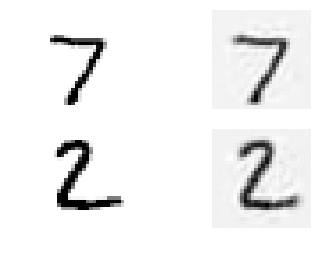

In [73]:
show_reconstructed_digits(
    X, outputs, './my_model_stacked_denoising_dropout.ckpt')